In [106]:
#from PyDAQmx import *
import scipy as sp
import time
import os
import sys
from scipy import interpolate
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
import GDD
from GDD import PicoScope  # module for pico_scope
from GDD import ZabberVoiceCoil as zv # module to operate stage 
from GDD import Fastplot as fp
import logging
#import numpy as np
#import ipywidgets as widgets
#from IPython.display import display
%matplotlib notebook


In [8]:
u = zv.ZabberVoiceCoil('COM3')  # start communication with stage
u.sin(1000,100)



ID OK:@01 0 OK IDLE NI 50419
b'@01 0 OK BUSY -- 0\r\n'
b'@01 0 OK BUSY -- 0\r\n'


In [19]:
u.sin_stop()
u.close()

b'@01 0 OK BUSY NI 0\r\n'
Communication closed...


In [98]:
ps = PicoScope.DAQ_parallel_channels(1e6)


PicoSDKCtypesError: PicoSDK returned 'PICO_NOT_FOUND'

In [34]:
tst= sp.transpose([timeS,data[:,0],data[:,1]])
tst.shape

(1000000, 3)

In [104]:
sp.save('2mm_scan_v1_20_v2_40_acc_800_cur_7.npy',sp.transpose([timeS,data[:,0],data[:,1]]))

In [105]:
ps.DAQ_close()

In [99]:
timeS,data = ps.DAQ_read()

<IPython.core.display.Javascript object>


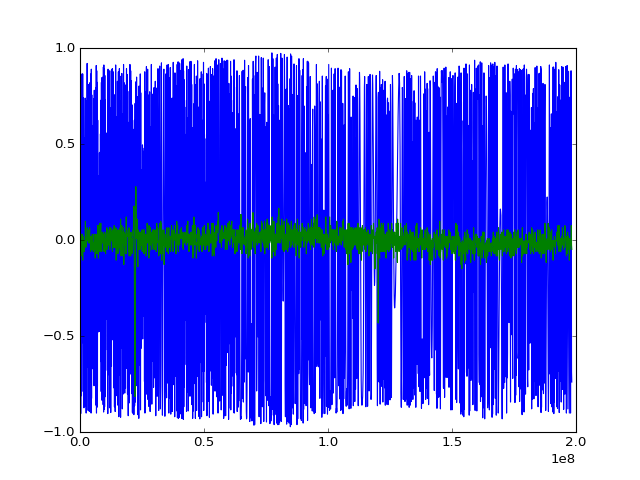

D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [101]:
# data = sp.load('2mm_scan_v1_30_v2_50_acc_5000.npy')
# timeS = data[:,0]
signal_HeNe = data[:,0]
signal_SC = data[:,1]

#timeS, signal_HeNe, signal_SC, Trigger = sp.loadtxt('gdd_test_data.txt',delimiter = ' ', unpack = True)

N=len(timeS)
R=1.0e6
D_time = 1/R
T = N/R
wl_laser = int(633e-9)  #in m
N_FFT = int(2**16)  
c = 299792458      #speed of light in m/s
N=int(1e6)


N_test =int(N/500)
timePlot = timeS[::N_test]
HeNe_plot = sp.zeros_like(timePlot)
for i in sp.arange(0, len(timePlot)-1, 2):
    HeNe_plot[i]=signal_HeNe[(i*N_test):(i*N_test+2*N_test)].max()
for i in sp.arange(1, len(timePlot), 2):
    HeNe_plot[i]=signal_HeNe[(i*N_test):(i*N_test+2*N_test)].min()

SC_plot = sp.zeros_like(timePlot)
for i in sp.arange(0, len(timePlot)-1, 2):
    SC_plot[i]=signal_SC[(i*N_test):(i*N_test+2*N_test)].max()
for i in sp.arange(1, len(timePlot), 2):
    SC_plot[i]=signal_SC[(i*N_test):(i*N_test+2*N_test)].min()
    
    
# ind_start = 4500
# ind_stop = 54500
# timeS = timeS[ind_start:ind_stop]
# signal_HeNe = signal_HeNe[ind_start:ind_stop]
# signal_SC = signal_SC[ind_start:ind_stop]

signal_HeNe=(signal_HeNe-signal_HeNe.mean())/(sp.absolute(signal_HeNe-signal_HeNe.mean())).max() #normalize and shift around zero
signal_SC=(signal_SC-signal_SC.mean())/(sp.absolute(signal_SC-signal_SC.mean())).max()

plt.figure()
plt.plot(timeS[:2e5:100],signal_HeNe[:2e5:100])
plt.plot(timeS[:2e5:100],signal_SC[:2e5:100])
#print('elapsed time : {:0.3f} s'.format(time.time()-t0))

elapsed time : 0.306 s


<IPython.core.display.Javascript object>


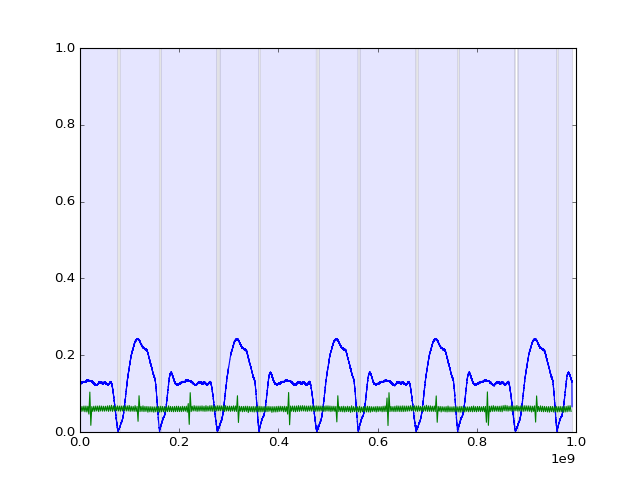

elapsed time : 0.659 s


In [103]:
t0 = time.time()

#the following lines solve issue if it is exactly 0 or end of array problem
signal_HeNe[sp.where(signal_HeNe==0)]=sys.float_info.epsilon#1e-100 #works with sign even if smaller than epsilon
zero_crossings = sp.append(0,sp.absolute(sp.diff(sp.sign(signal_HeNe)))) > 0#the [] is important to only get the indizes back

kern_win_size = 501  # it was 2001 
x_kern = sp.linspace(-1,1,kern_win_size)
kern = sp.exp(-x_kern**2/4)
kern /= kern.sum() # equivalent to kern = kern/kern.sum()

MA = sp.convolve(zero_crossings, kern, mode='same') #moving average
speed_threshold = MA.max() * 0.05 # threshold at 5% of speed
speed_win = MA > speed_threshold


win_diff = sp.append(0,sp.diff(sp.array(speed_win,'int')))
start_ind = sp.where(win_diff > 0)[0][1:-1]
stop_ind = sp.where(win_diff < 0)[0][1:-1]


if start_ind[0] > stop_ind[0]:
    stop_ind = stop_ind[1:]

if start_ind[-1] > stop_ind[-1]:
    start_ind = start_ind[:-1]

if len(start_ind) != len(stop_ind):
    print('start_ind and stop_ind not the same length.')

print('elapsed time : {:0.3f} s'.format(time.time()-t0))
    
plt.figure()
# plt.plot(timeS,zero_crossings)
plt.plot(timeS,MA)
plt.fill_between(timeS,speed_win,alpha = 0.1)

# plt.plot(timeS[start_ind],sp.zeros(len(start_ind)),'r.')
# plt.plot(timeS[stop_ind],sp.zeros(len(stop_ind)),'k.')
plt.plot(timePlot,SC_plot / 1e4)
# plt.show()

print('elapsed time : {:0.3f} s'.format(time.time()-t0))

<IPython.core.display.Javascript object>


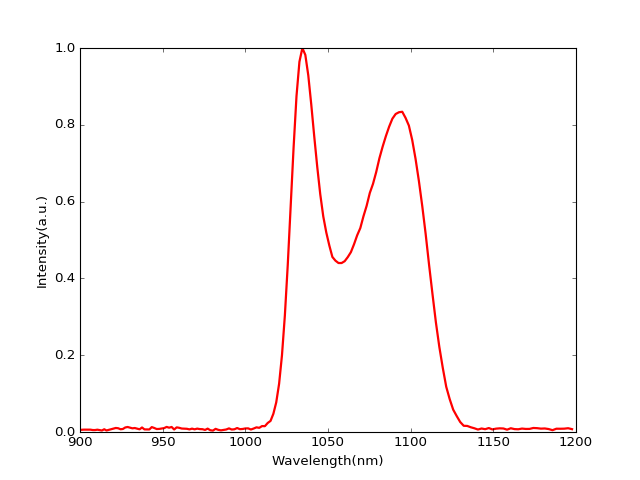

D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


i not skiped : 0, time win : 111104.111
z_range = 0.000
i not skiped : 1, time win : 110112.110
z_range = 0.000
i not skiped : 2, time win : 269824.270
z_range = 0.003
i not skiped : 3, time win : 205344.205
z_range = 0.001
i not skiped : 4, time win : 110112.110
z_range = 0.000
i not skiped : 5, time win : 205344.205
z_range = 0.001
i not skiped : 6, time win : 110112.110
z_range = 0.000
i not skiped : 7, time win : 110112.110
z_range = 0.000
i not skiped : 8, time win : 112096.112
z_range = 0.000
i not skiped : 9, time win : 118048.118
z_range = 0.000
i not skiped : 10, time win : 127968.128
z_range = 0.000
i not skiped : 11, time win : 146816.147
z_range = 0.000
i not skiped : 12, time win : 46307598.308
z_range = 0.752
i not skiped : 13, time win : 113088.113
z_range = 0.000
i not skiped : 14, time win : 110112.110
z_range = 0.000
i not skiped : 15, time win : 110112.110
z_range = 0.000
i not skiped : 16, time win : 110112.110
z_range = 0.000
i not skiped : 17, time win : 110112.11

In [132]:
wl_laser = 633e-9
N_FFT = 2**16

plt.figure()
z_range = 0.6e-3
z = sp.linspace(-z_range/2, z_range/2,N_FFT )
dt = (z.max() - z.min())/(len(z)-1) / c 
freq = sp.fftpack.fftfreq(N_FFT,dt)
wl = c / freq
omega = 2 * sp.pi * freq
d_omega = omega[1] - omega[0]
phase_swap = sp.repeat([-1,1],N_FFT/2)

phase_avg_d2 = sp.zeros_like(freq)

i_avg = 0
for i in range(len(start_ind)):
    win_time_span = timeS[stop_ind[i]] - timeS[start_ind[i]]
    if win_time_span < 30e-3:
        continue
    print('i not skiped : {}, time win : {:0.3f}'.format(i,win_time_span))
    time_win = timeS[start_ind[i]:stop_ind[i]]
    signal_HeNe_win = signal_HeNe[start_ind[i]:stop_ind[i]]
    signal_SC_win = signal_SC[start_ind[i]:stop_ind[i]]
    
    intz = sp.where(sp.absolute(sp.diff(sp.sign(signal_HeNe_win))))[0]
    #solve issue if end of array problem
    if intz[-1]==(len(time_win)-1):
        intz=intz[:-1]
   
    
    #linear interpolated zero
    time0s = time_win[intz]+signal_HeNe_win[intz]*D_time/(signal_HeNe_win[intz]-signal_HeNe_win[intz+1])
    position_0s = sp.arange(0,len(time0s))*wl_laser/2
    z_scanned = position_0s.max() - position_0s.min()
    print('z_range = {:0.3f}'.format(z_scanned*1e3))
    if z_scanned < z_range:
        continue
    
    f = interpolate.interp1d(time0s,position_0s)
    mask = (time_win > time0s.min()) & (time_win < time0s.max())
    time_win_valid = time_win[mask]
    pos_interp = f(time_win_valid)
    pos_interp = pos_interp - (pos_interp.max() - pos_interp.min())/2
    
    
    
    
    # interpolate the SC data into z
    f_interp_SC = interpolate.interp1d(pos_interp, signal_SC_win[mask])
    signal_SC_win_interpalated = f_interp_SC(z)
    
    spect_smp = sp.fft(signal_SC_win_interpalated) * phase_swap
    spectra = sp.absolute(spect_smp)/sp.absolute(spect_smp).max()
    phase_smp = sp.angle(spect_smp)
    phase_smp = sp.unwrap(phase_smp)
    phase_smp_d2 = sp.append(sp.append(0,sp.diff(phase_smp,2)),0)/d_omega**2 
    phase_avg_d2 = (phase_avg_d2*i+sp.convolve(phase_smp_d2, sp.ones(2)/2, mode='same'))/(i+1)
    
    
#     plt.plot(time_win[mask],pos_interp * 1e3)
#     plt.plot(z,signal_SC_win_interpalated)
    pl_mask = (wl > 900e-9)*(wl < 1200e-9)
    #plt.plot(wl[pl_mask]*1e9, phase_smp_d2[pl_mask] * 1e30)
    #plt.plot(wl[pl_mask]*1e9,sp.absolute(spect_smp[pl_mask]))
    
#plt.ylabel('signal (a.u)')
#plt.xlabel('z (s)')
# plt.plot(wl[pl_mask]*1e9, phase_smp[pl_mask] * 1e30, 'r',lw=2)
plt.plot(wl[pl_mask]*1e9, spectra[pl_mask] , 'r',lw=2)
#plt.plot(wl[pl_mask]*1e9,sp.convolve(phase_avg_d2, sp.ones(3)/3, mode='same')[pl_mask]*1e30)
# plt.grid()
plt.xlabel('Wavelength(nm)')
plt.ylabel('Intensity(a.u.)')
#plt.xlim(0.336,0.346)
plt.savefig('Spectra', format = None)  


<IPython.core.display.Javascript object>


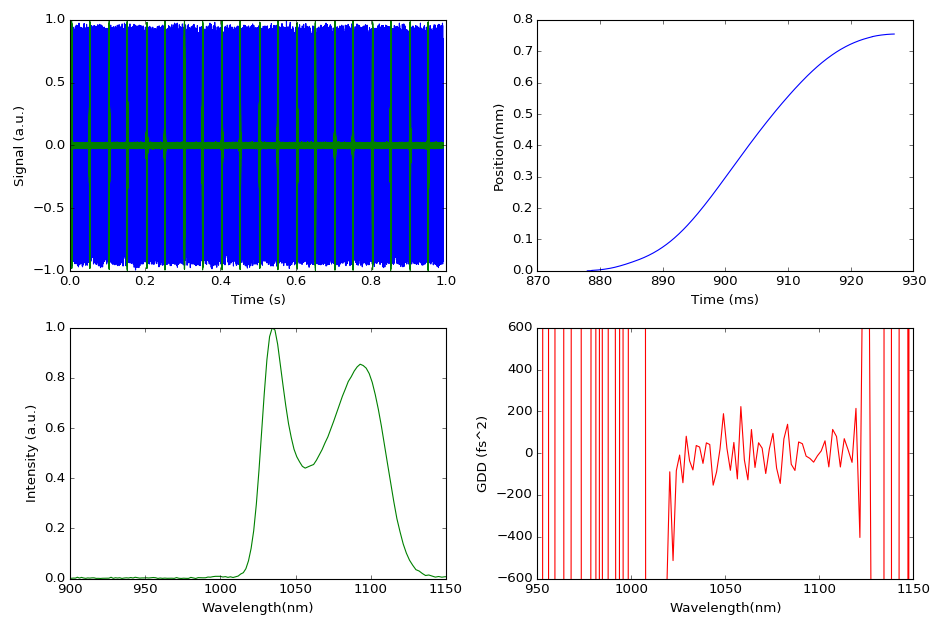

In [49]:
t = fp.FastPlotNotebook()
t.update_plot(timeS,signal_HeNe,signal_SC,time0s,position_0s,wl,spectra,phase_avg_d2)



NameError: name 'double' is not defined